# CS5100 Group Project

### Import libraries

In [89]:
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,15
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from math import sqrt

### Read the dataset

In [90]:
#Read the dataset for NFLX
df=pd.read_csv("NFLX.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-16,309.940002,310.489990,303.609985,306.019989,306.019989,8038600
1,2022-11-15,309.200012,312.709991,302.549988,310.200012,310.200012,14626900
2,2022-11-14,290.000000,311.000000,288.190002,299.269989,299.269989,17978200
3,2022-11-11,274.470001,290.660004,271.559998,290.130005,290.130005,9567300
4,2022-11-10,265.989990,275.359985,260.089996,274.970001,274.970001,9667300


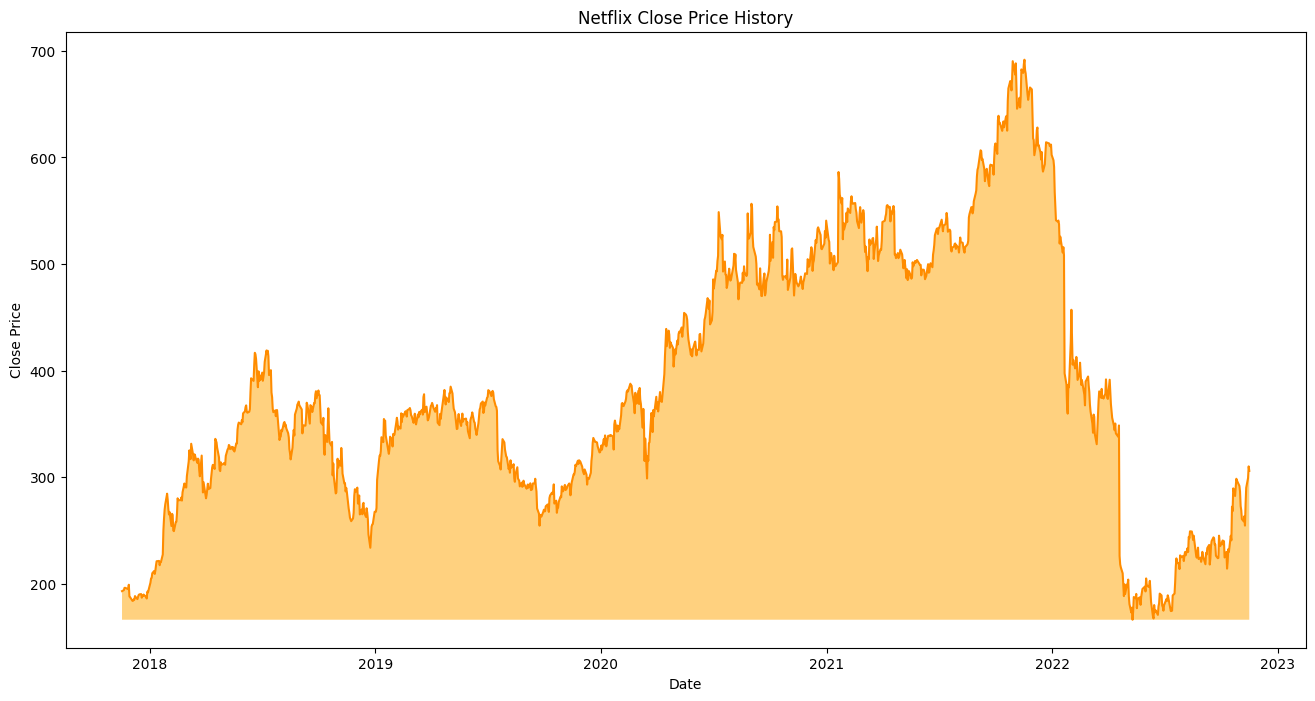

In [91]:
#Analyze the Netflix closing prices from datafrram
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
Closemin = df.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='NFLX Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Netflix Close Price History")
plt.fill_between(df.index, Closemin, df.Close, facecolor='orange', alpha = 0.5)

### Unit Test

In [122]:
import datetime
def test_inputDate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d %H:%M:%S')
        print("correct format")
    except ValueError:
        print(date_text)
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")


### Test Case for Date Format

In [127]:
test_inputDate("2022-01-20 00:00:00")

correct format


In [128]:
test_inputDate("2022-01-39 00:00:00")

2022-01-39 00:00:00


ValueError: Incorrect data format, should be YYYY-MM-DD

In [129]:
test_inputDate("2022-01-20 100:00:00")

2022-01-20 100:00:00


ValueError: Incorrect data format, should be YYYY-MM-DD

In [125]:
#Sort the dataset on date time and filter “Date” and “Close” columns
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date

new_dataset.drop("Date",axis=1,inplace=True)


final_dataset=new_dataset.values

train_data=final_dataset[0:1007,:]
valid_data=final_dataset[1007:,:]

scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):

    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_test_data, y_test_data = [],[]
for i in range(60,len(valid_data)):
    x_test_data.append(scaled_data[i-60:i,0])
    y_test_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

x_test_data,y_test_data=np.array(x_test_data),np.array(y_test_data)
x_test_data = np.reshape(x_test_data,(x_test_data.shape[0], x_test_data.shape[1], 1))

print(x_train_data.shape, y_train_data.shape)
print(x_test_data.shape, y_test_data.shape)

(947, 60, 1) (947,)
(191, 60, 1) (191,)


In [ ]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=( x_train_data.shape[1], 1)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
history = lstm_model.fit(x_train_data,y_train_data,epochs=50,batch_size=100, verbose=2,shuffle=False, validation_data=(x_test_data, y_test_data))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [93]:
predicted_closing_price=lstm_model.predict(x_test_data)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
mae=mean_absolute_percentage_error(y_test_data, predicted_closing_price)
print("mae: ", mae)
mse=mean_squared_error(y_test_data, predicted_closing_price)
print("mse: ", mse)
rmse = sqrt(mse)
print("rmse: ", rmse)

6/6 [==============================] - 1s 12ms/step
mae:  260.4406609813895
mse:  7171.22892697656
rmse:  84.68310886461691


Epoch 1/50
11/11 [==============================] - 10s 254ms/step - loss: 0.6282 - accuracy: 0.0000e+00 - val_loss: 0.5897 - val_accuracy: 0.0035
Epoch 2/50
11/11 [==============================] - 1s 49ms/step - loss: 0.6268 - accuracy: 0.0000e+00 - val_loss: 0.5784 - val_accuracy: 0.0035
Epoch 3/50
11/11 [==============================] - 1s 54ms/step - loss: 0.6265 - accuracy: 0.0000e+00 - val_loss: 0.5771 - val_accuracy: 0.0035
Epoch 4/50
11/11 [==============================] - 1s 64ms/step - loss: 0.6262 - accuracy: 0.0000e+00 - val_loss: 0.5769 - val_accuracy: 0.0035
Epoch 5/50
11/11 [==============================] - 1s 55ms/step - loss: 0.6260 - accuracy: 0.0000e+00 - val_loss: 0.5775 - val_accuracy: 0.0035
Epoch 6/50
11/11 [==============================] - 1s 55ms/step - loss: 0.6259 - accuracy: 0.0000e+00 - val_loss: 0.5767 - val_accuracy: 0.0035
Epoch 7/50
11/11 [==============================] - 1s 56ms/step - loss: 0.6259 - accuracy: 0.0000e+00 - val_loss: 0.5791 - val_

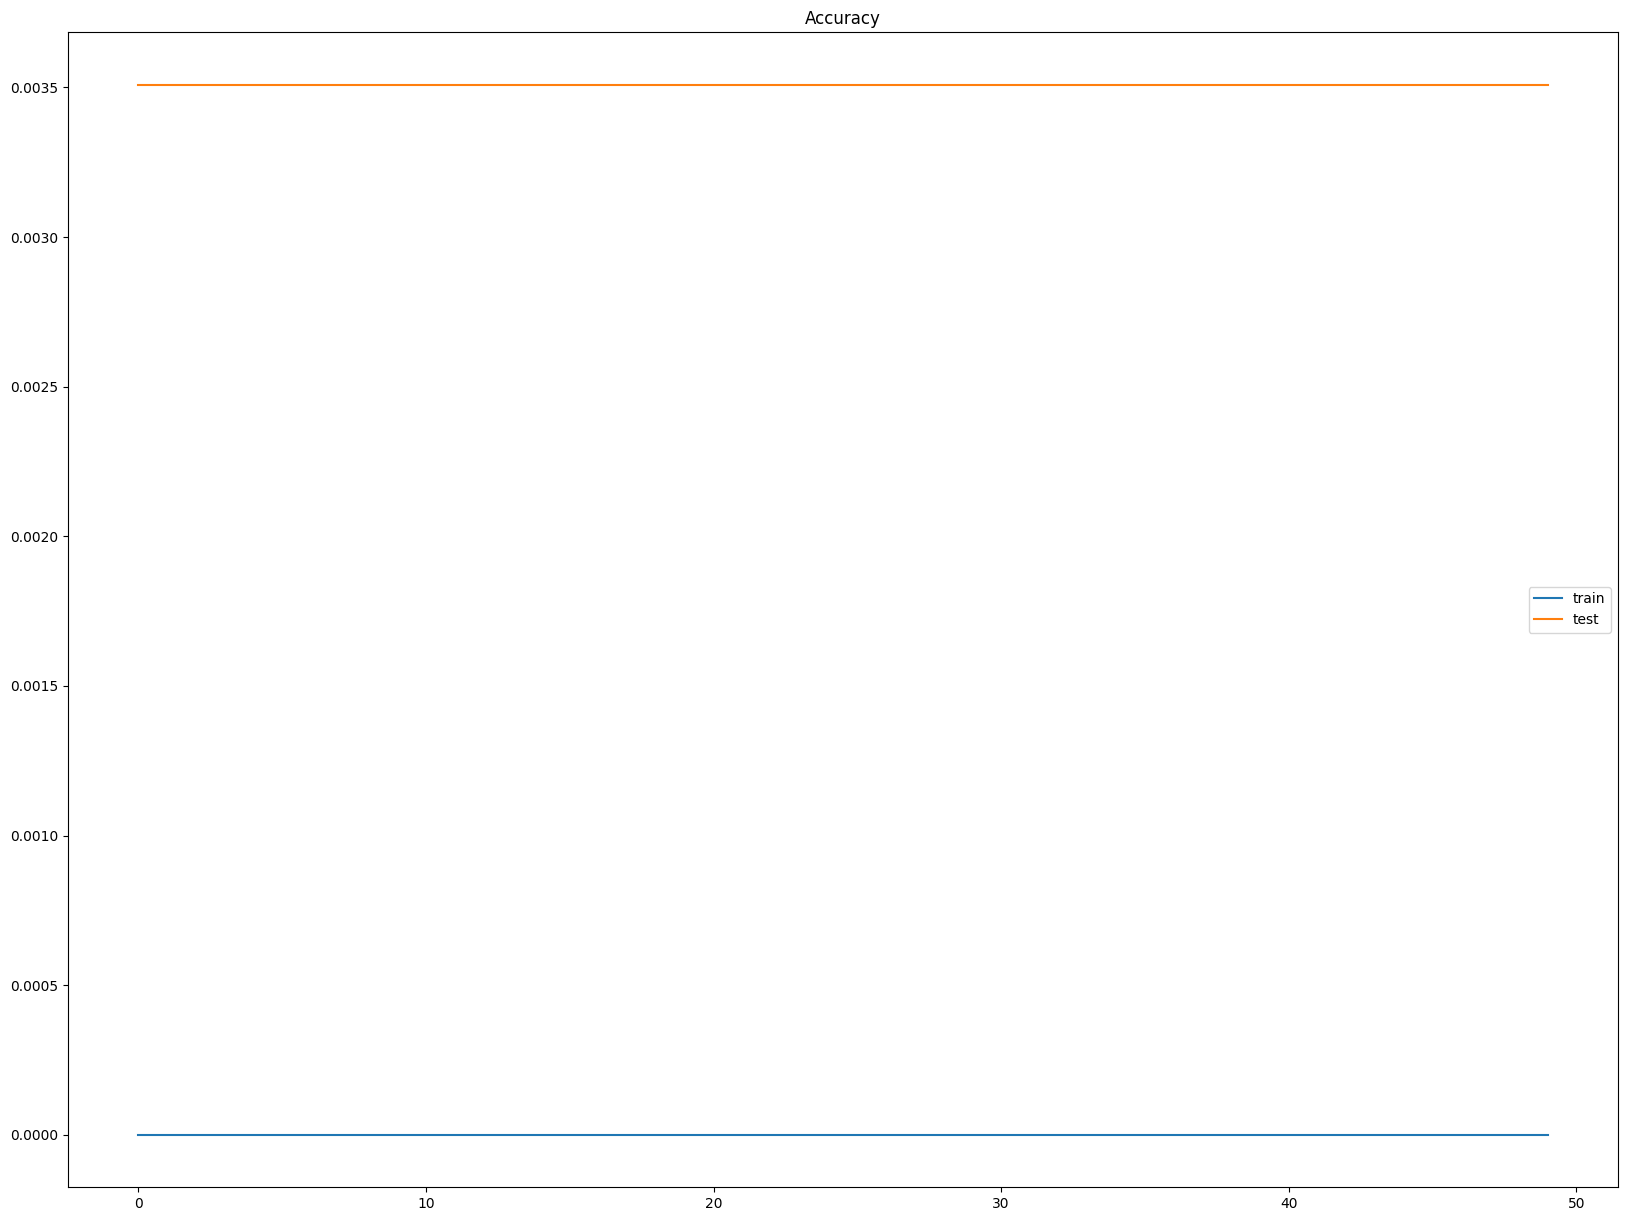

In [94]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam',
                             metrics=["accuracy"])
history = lstm_model.fit(x_train_data,y_train_data,epochs=50,batch_size=64, validation_split=0.3)
print("history.history:{}".format(history.history))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [95]:
# #Sort the dataset on date time and filter “Date” and “Close” columns
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import SGD
# data=df.sort_index(ascending=True,axis=0)
# new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
# for i in range(0,len(data)):
#     new_dataset["Date"][i]=data['Date'][i]
#     new_dataset["Close"][i]=data["Close"][i]
# #Normalize the new filtered dataset:
# scaler=MinMaxScaler(feature_range=(0,1))
# new_dataset.index=new_dataset.Date
# new_dataset.drop("Date",axis=1,inplace=True)
# final_dataset=new_dataset.values
#
# train_data=final_dataset[0:1007,:]
# valid_data=final_dataset[1007:,:]
#
# scaled_data=scaler.fit_transform(final_dataset)
# x_train_data,y_train_data=[],[]
# for i in range(60,len(train_data)):
#     x_train_data.append(scaled_data[i-60:i,0])
#     y_train_data.append(scaled_data[i,0])
#
# x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
# x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
#
# #Build and train the LSTM model:
# lstm_model=Sequential()
# lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
# lstm_model.add(LSTM(units=50))
# lstm_model.add(Dense(1))
# inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
# inputs_data=inputs_data.reshape(-1,1)
# inputs_data=scaler.transform(inputs_data)
# epochs = 50
# learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8
# sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# lstm_model.compile(loss='mean_squared_error',optimizer=sgd, metrics=['accuracy'])
# #lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
# # history = lstm_model.fit(x_train_data,y_train_data,
# #                       epochs=1,
# #                       batch_size=64,
# #                       verbose=1,
# #                       validation_data=(x_train_data,y_train_data))
# # print("history.history:{}".format(history.history))

In [96]:
# # Take a sample of a dataset to make stock price predictions using the LSTM model
# X_test, Y_test=[],[]
# for i in range(60,inputs_data.shape[0]):
#     X_test.append(inputs_data[i-60:i,0])
#     Y_test.append(inputs_data[i,0])
# X_test=np.array(X_test)
# #X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
# Y_test=np.array(Y_test)
# #Y_test=np.reshape(Y_test,(Y_test.shape[0],Y_test.shape[1],1))
#
# predicted_closing_price=lstm_model.predict(X_test)
# predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
#
# history = lstm_model.fit(x_train_data,y_train_data,
#                        epochs=20,
#                        batch_size=64,
#                        verbose=1,
#                        validation_data=(X_test, Y_test))
# print("history.history:{}".format(history.history))

In [97]:
#Read the dataset for AAPL
df1=pd.read_csv("AAPL.csv")
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2022-11-17,146.429993,151.479996,146.149994,150.720001,150.720001,80278500,AAPL
1,2022-11-16,149.130005,149.869995,147.289993,148.789993,148.789993,64218300,AAPL
2,2022-11-15,152.220001,153.589996,148.559998,150.039993,150.039993,89868300,AAPL
3,2022-11-14,148.970001,150.279999,147.429993,148.279999,148.279999,73374100,AAPL
4,2022-11-11,145.820007,150.009995,144.369995,149.699997,149.699997,93903800,AAPL


In [98]:
#Read the dataset for META
df2=pd.read_csv("META.csv")
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2022-11-17,110.410004,112.330002,109.800003,111.449997,111.449997,35017300,META
1,2022-11-16,114.500000,116.080002,112.660004,113.230003,113.230003,33287800,META
2,2022-11-15,116.070000,118.739998,114.410004,117.080002,117.080002,50670500,META
3,2022-11-14,110.989998,116.269997,110.800003,114.220001,114.220001,53395000,META
4,2022-11-11,109.230003,114.900002,108.809998,113.019997,113.019997,59836400,META


In [99]:
#Read the dataset for AAPL
df3=pd.read_csv("MSFT.csv")
df3.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2022-11-17,237.779999,243.250000,237.630005,241.679993,241.679993,23103700,MSFT
1,2022-11-16,242.789993,243.800003,240.419998,241.729996,241.729996,24093300,MSFT
2,2022-11-15,245.660004,247.000000,240.029999,241.970001,241.290009,31390100,MSFT
3,2022-11-14,241.990005,243.910004,239.210007,241.550003,240.871185,31123300,MSFT
4,2022-11-11,242.990005,247.990005,241.929993,247.110001,246.415558,34600900,MSFT


In [100]:
#Read the dataset for AAPL
df4=pd.read_csv("TSLA.csv")
df4.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2022-11-17,183.960007,186.160004,180.899994,183.169998,183.169998,64187200,TSLA
1,2022-11-16,191.509995,192.570007,185.660004,186.919998,186.919998,66567600,TSLA
2,2022-11-15,195.880005,200.820007,192.059998,194.419998,194.419998,91293800,TSLA
3,2022-11-14,192.770004,195.729996,186.339996,190.949997,190.949997,92226600,TSLA
4,2022-11-11,186.000000,196.520004,182.589996,195.970001,195.970001,114229200,TSLA


### Analyze the closing prices from dataframe

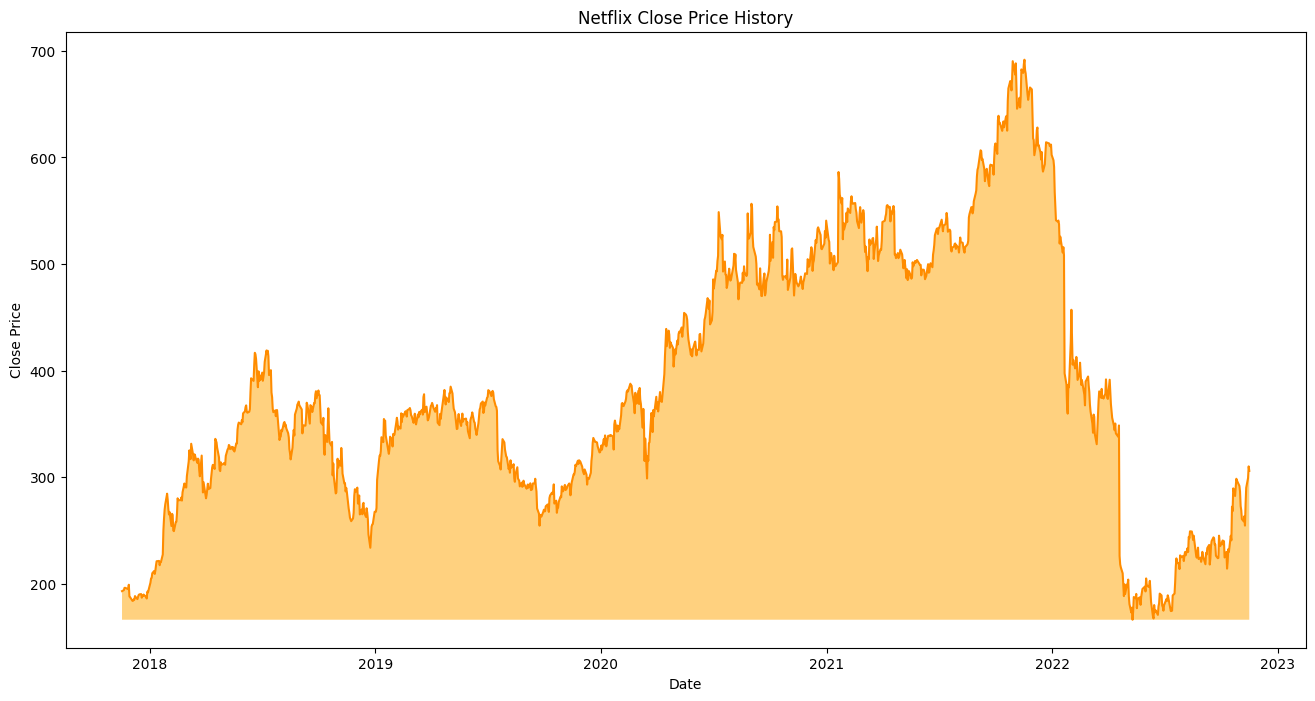

In [101]:
#Analyze the Netflix closing prices from datafrram
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
Closemin = df.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='NFLX Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Netflix Close Price History")
plt.fill_between(df.index, Closemin, df.Close, facecolor='orange', alpha = 0.5)

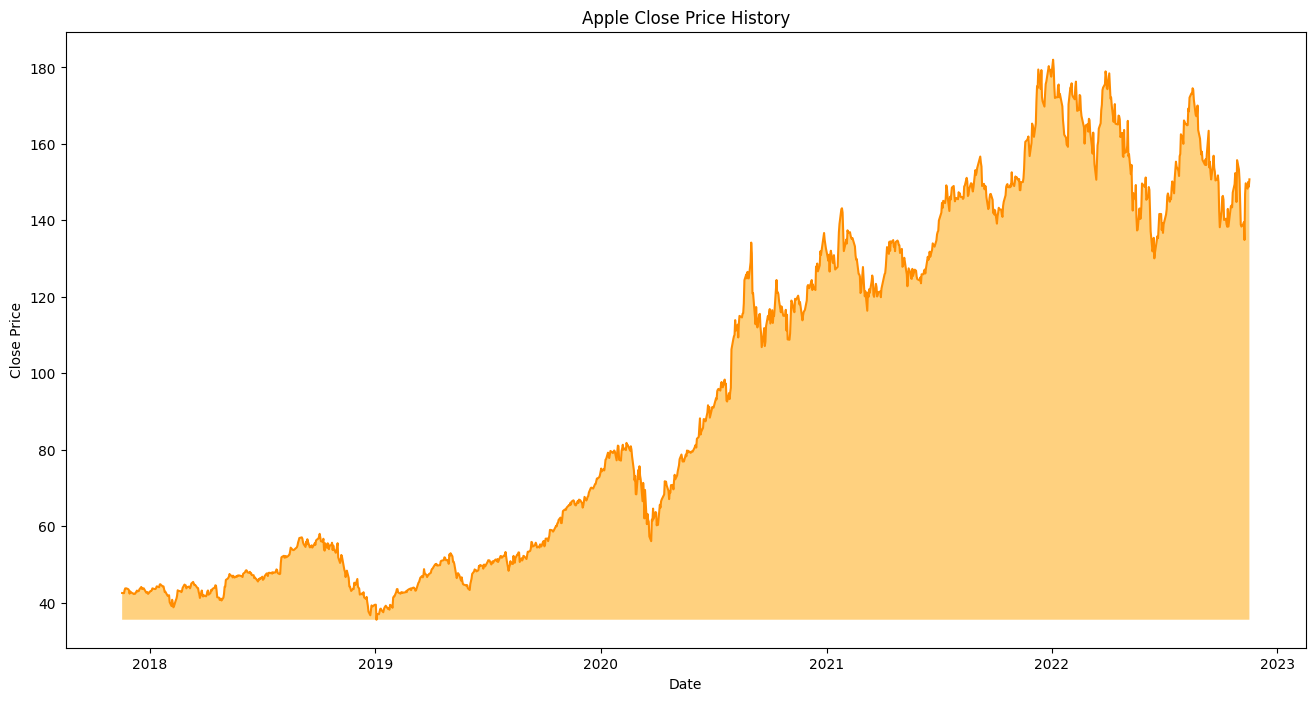

In [102]:
#Analyze the Apple closing prices from dataframe
df1["Date"]=pd.to_datetime(df1.Date,format="%Y-%m-%d")
df1.index=df1['Date']
Closemin = df1.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df1["Close"],label='Apple Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Apple Close Price History")
plt.fill_between(df1.index, Closemin, df1.Close, facecolor='orange', alpha = 0.5)

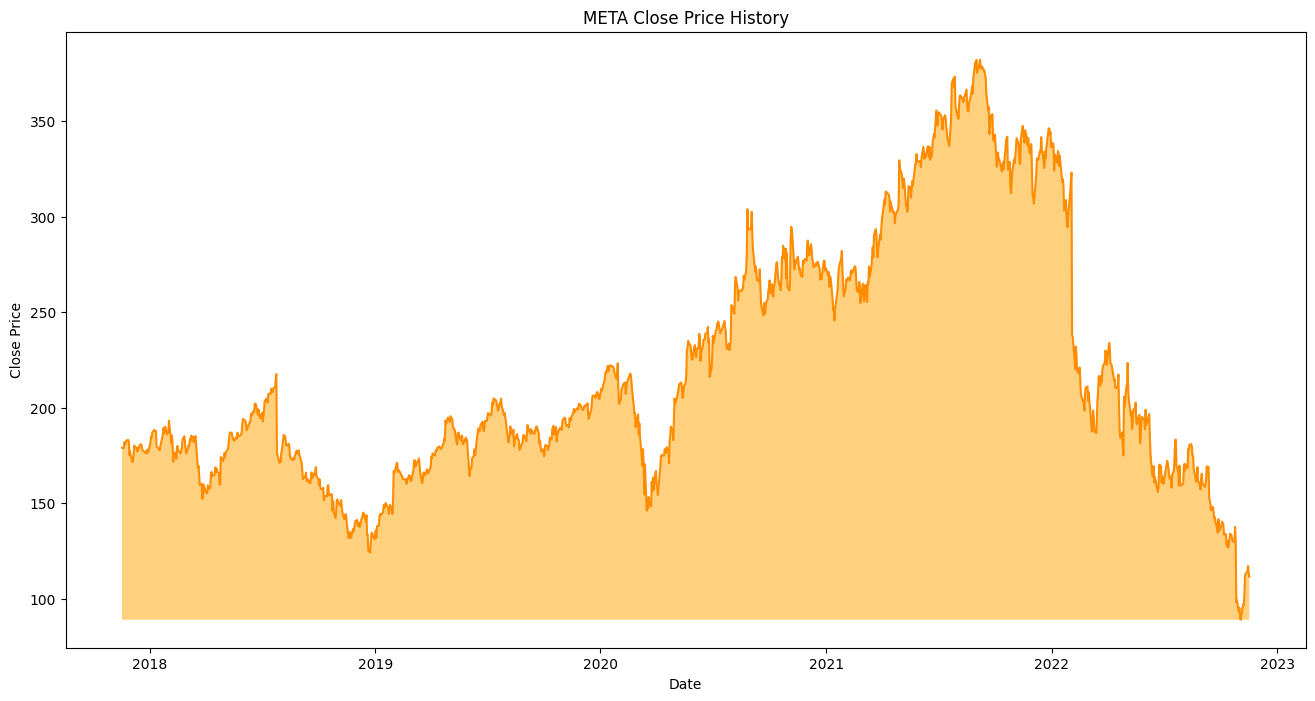

In [103]:
#Analyze the META closing prices from dataframe
df2["Date"]=pd.to_datetime(df2.Date,format="%Y-%m-%d")
df2.index=df2['Date']
Closemin = df2.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df2["Close"],label='META Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("META Close Price History")
plt.fill_between(df2.index, Closemin, df2.Close, facecolor='orange', alpha = 0.5)

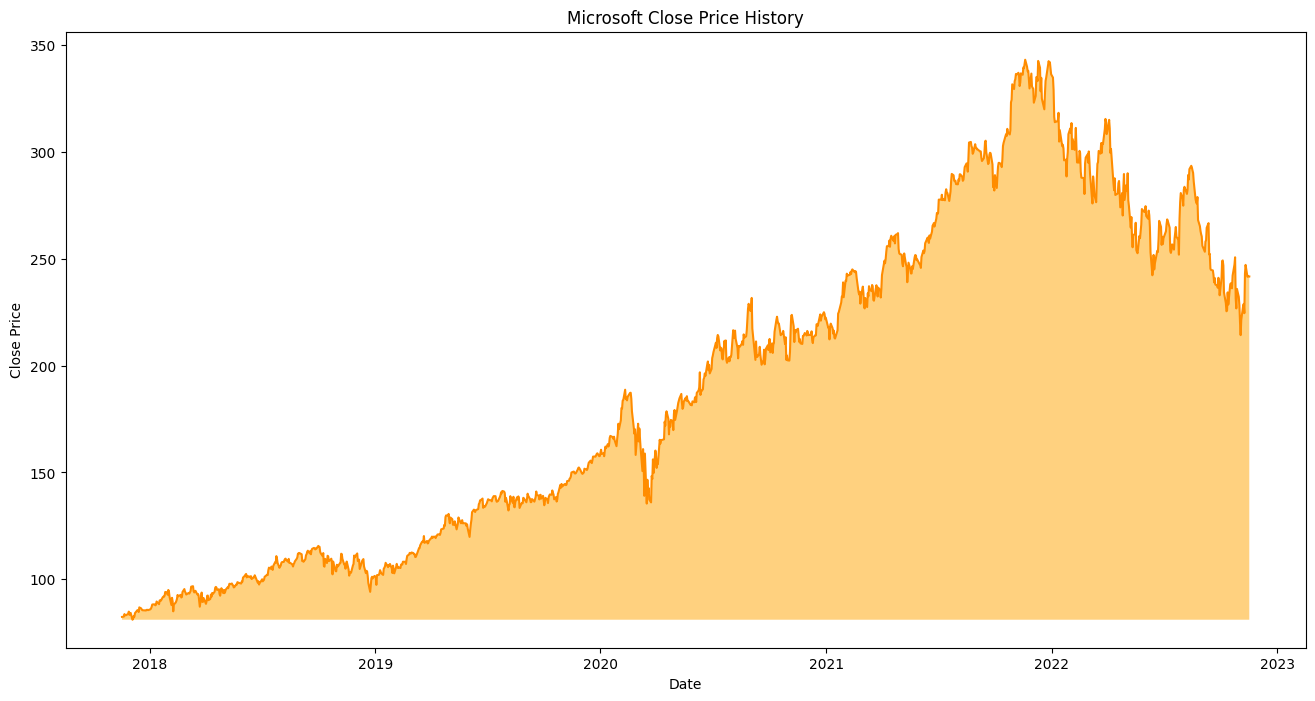

In [104]:
#Analyze the Microsoft closing prices from dataframe
df3["Date"]=pd.to_datetime(df3.Date,format="%Y-%m-%d")
df3.index=df3['Date']
Closemin = df3.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df3["Close"],label='MSFT Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Microsoft Close Price History")
plt.fill_between(df3.index, Closemin, df3.Close, facecolor='orange', alpha = 0.5)

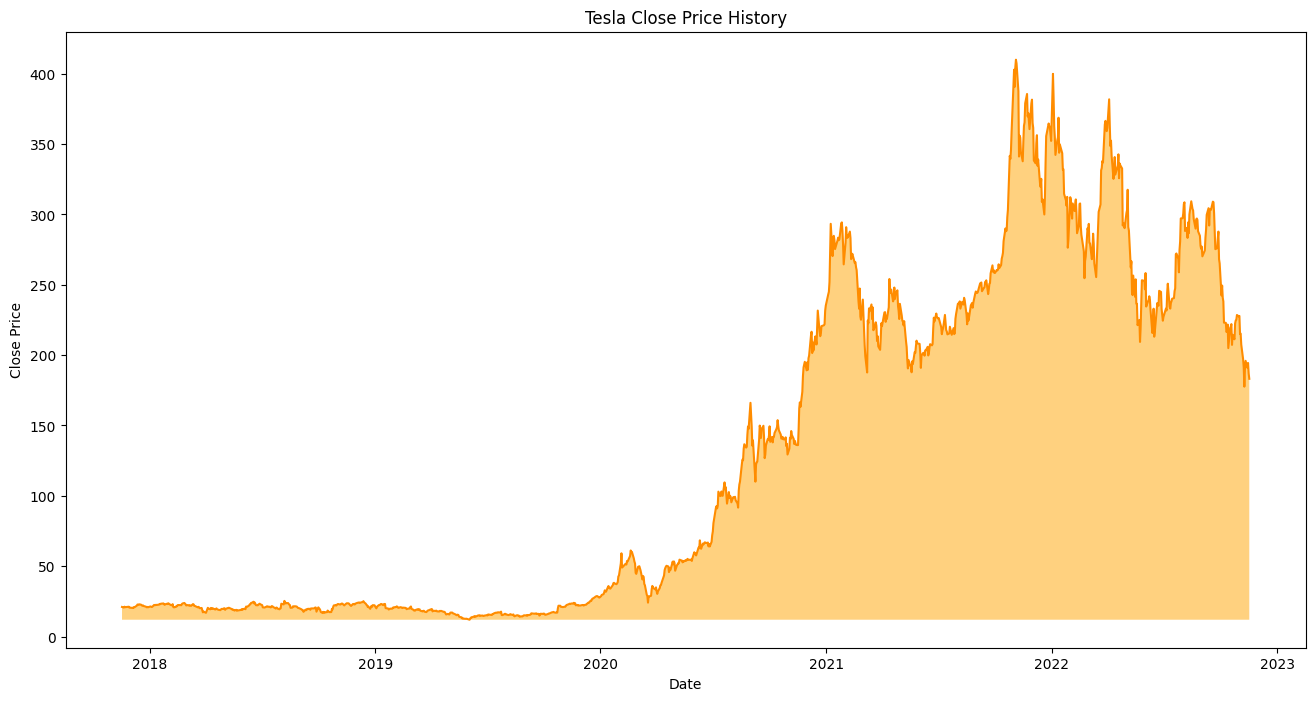

In [105]:
#Analyze the Tesla closing prices from dataframe
df4["Date"]=pd.to_datetime(df4.Date,format="%Y-%m-%d")
df4.index=df4['Date']
Closemin = df4.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df4["Close"],label='Tesla Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Tesla Close Price History")
plt.fill_between(df4.index, Closemin, df4.Close, facecolor='orange', alpha = 0.5)

### Build and train the LSTM model for Netflix

In [106]:
#Sort the dataset on date time and filter “Date” and “Close” columns
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:1007,:]
valid_data=final_dataset[1007:,:]

scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

#Build and train the LSTM model:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
lstm_model.compile(loss='mean_squared_error',optimizer=sgd, metrics=['accuracy'])
#lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
# history = lstm_model.fit(x_train_data,y_train_data,
#                       epochs=1,
#                       batch_size=64,
#                       verbose=1,
#                       validation_data=(x_train_data,y_train_data))
# print("history.history:{}".format(history.history))

/usr/local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [107]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test, Y_test=[],[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
    Y_test.append(inputs_data[i,0])
X_test=np.array(X_test)
#X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
Y_test=np.array(Y_test)
#Y_test=np.reshape(Y_test,(Y_test.shape[0],Y_test.shape[1],1))

predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

history = lstm_model.fit(x_train_data,y_train_data,
                       epochs=20,
                       batch_size=64,
                       verbose=1,
                       validation_data=(X_test, Y_test))
print("history.history:{}".format(history.history))

8/8 [==============================] - 1s 9ms/step
Epoch 1/20
15/15 [==============================] - 6s 108ms/step - loss: 0.0734 - accuracy: 0.0011 - val_loss: 0.0487 - val_accuracy: 0.0040
Epoch 2/20
15/15 [==============================] - 1s 41ms/step - loss: 0.0137 - accuracy: 0.0011 - val_loss: 0.0060 - val_accuracy: 0.0040
Epoch 3/20
15/15 [==============================] - 1s 47ms/step - loss: 0.0023 - accuracy: 0.0011 - val_loss: 0.0056 - val_accuracy: 0.0040
Epoch 4/20
15/15 [==============================] - 1s 42ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 0.0058 - val_accuracy: 0.0040
Epoch 5/20
15/15 [==============================] - 1s 42ms/step - loss: 0.0016 - accuracy: 0.0011 - val_loss: 0.0064 - val_accuracy: 0.0040
Epoch 6/20
15/15 [==============================] - 1s 42ms/step - loss: 0.0017 - accuracy: 0.0011 - val_loss: 0.0051 - val_accuracy: 0.0040
Epoch 7/20
15/15 [==============================] - 1s 42ms/step - loss: 0.0017 - accuracy: 0.0011 - v

/var/folders/xs/h3x4fh5s5cg16zvnwkkw6l7w0000gn/T/ipykernel_1666/1638199167.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


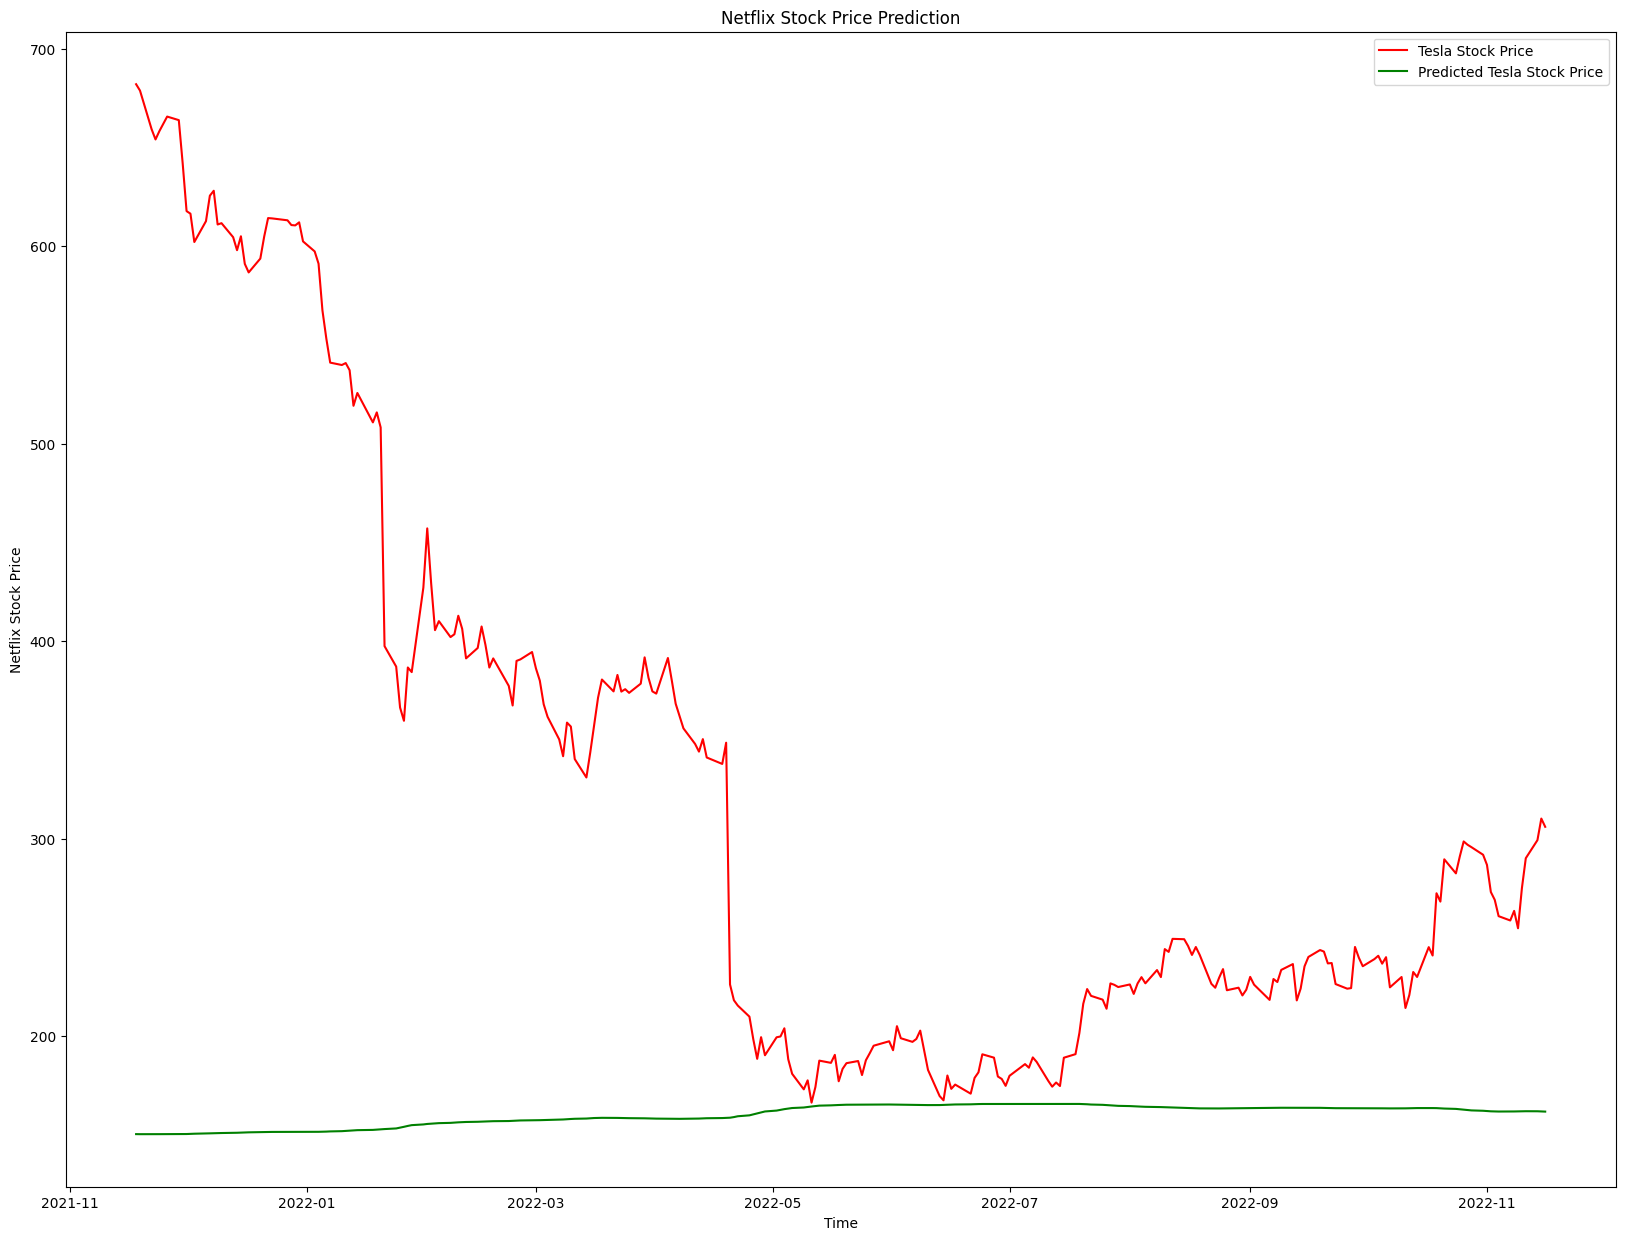

In [108]:
#Save the LSTM model
lstm_model.save("saved_model_NFLX.h5")

#Visualize the predicted stock costs with actual stock costs
train_data=new_dataset[:1007]
valid_data=new_dataset[1007:]

valid_data['Predictions']=predicted_closing_price
plt.plot(valid_data['Close'], color = 'red', label = 'Tesla Stock Price')
plt.plot(valid_data['Predictions'], color = 'green', label = 'Predicted Tesla Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price')

# displaying the title
plt.title("Netflix Stock Price Prediction")
plt.show()


### Build and train the LSTM model for Apple

In [109]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data1=df1.sort_index(ascending=True,axis=0)
new_dataset1=pd.DataFrame(index=range(0,len(df1)),columns=['Date','Close'])
for i in range(0,len(data1)):
    new_dataset1["Date"][i]=data1['Date'][i]
    new_dataset1["Close"][i]=data1["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset1.index=new_dataset1.Date
new_dataset1.drop("Date",axis=1,inplace=True)
final_dataset1=new_dataset1.values

train_data1=final_dataset1[0:1007,:]
valid_data1=final_dataset1[1007:,:]

scaled_data1=scaler.fit_transform(final_dataset1)
x_train_data1,y_train_data1=[],[]
for i in range(60,len(train_data1)):
    x_train_data1.append(scaled_data1[i-60:i,0])
    y_train_data1.append(scaled_data1[i,0])

x_train_data1,y_train_data1=np.array(x_train_data1),np.array(y_train_data1)
x_train_data1=np.reshape(x_train_data1,(x_train_data1.shape[0],x_train_data1.shape[1],1))

#Build and train the LSTM model:
lstm_model1=Sequential()
lstm_model1.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data1.shape[1],1)))
lstm_model1.add(LSTM(units=50))
lstm_model1.add(Dense(1))
inputs_data1=new_dataset1[len(new_dataset1)-len(valid_data1)-60:].values
inputs_data1=inputs_data1.reshape(-1,1)
inputs_data1=scaler.transform(inputs_data1)
lstm_model1.compile(loss='mean_squared_error',optimizer='adam')
lstm_model1.fit(x_train_data1,y_train_data1,epochs=1,batch_size=1,verbose=2)

947/947 - 20s - loss: 0.0019 - 20s/epoch - 21ms/step


8/8 [==============================] - 1s 11ms/step


/var/folders/xs/h3x4fh5s5cg16zvnwkkw6l7w0000gn/T/ipykernel_1666/1767354640.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data1['Predictions']=predicted_closing_price1


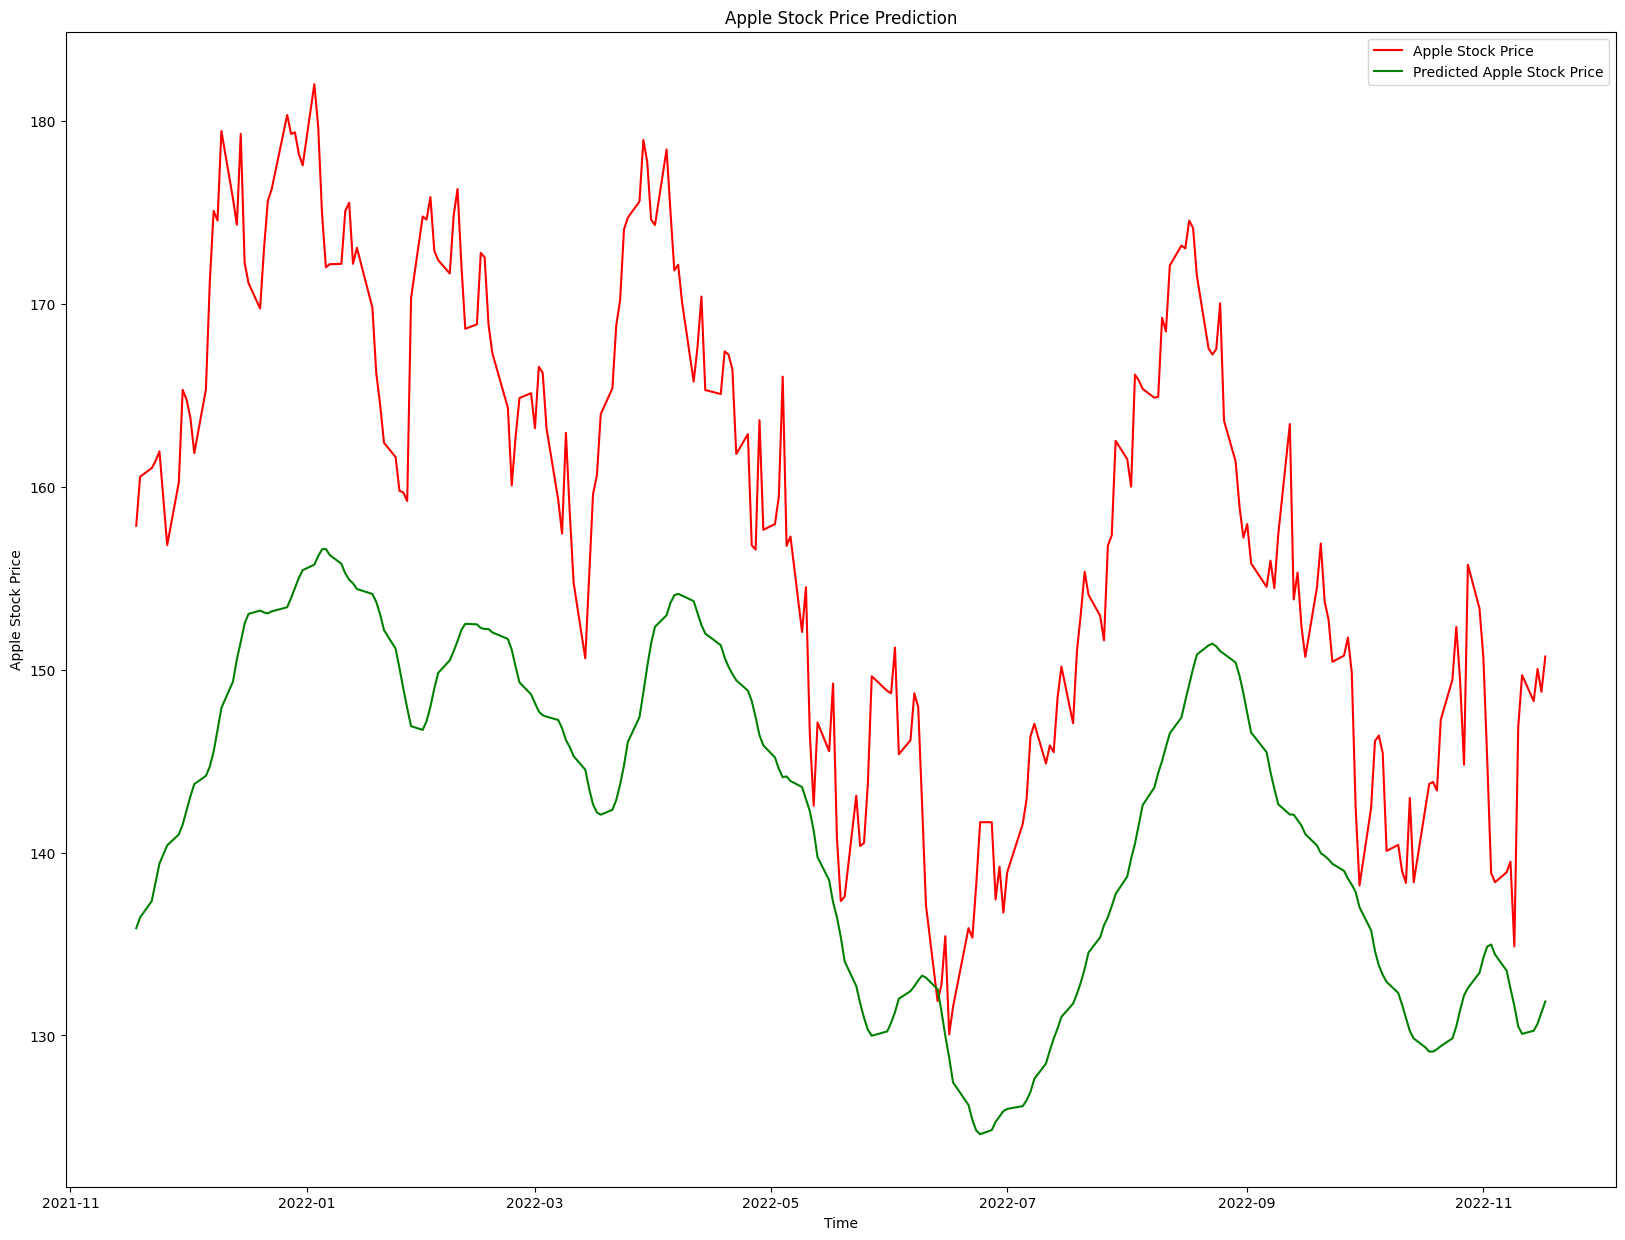

In [110]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test1=[]
for i in range(60,inputs_data1.shape[0]):
    X_test1.append(inputs_data1[i-60:i,0])
X_test1=np.array(X_test1)
X_test1=np.reshape(X_test1,(X_test1.shape[0],X_test1.shape[1],1))
predicted_closing_price1=lstm_model1.predict(X_test1)
predicted_closing_price1=scaler.inverse_transform(predicted_closing_price1)
#Save the LSTM model
lstm_model1.save("saved_model_AAPL.h5")

#Visualize the predicted stock costs with actual stock costs
train_data1=new_dataset1[:1007]
valid_data1=new_dataset1[1007:]
valid_data1['Predictions']=predicted_closing_price1
#plt.plot(train_data1["Close"])
#plt.plot(valid_data1[['Close',"Predictions"]])
plt.plot(valid_data1['Close'], color = 'red', label = 'Apple Stock Price')
plt.plot(valid_data1['Predictions'], color = 'green', label = 'Predicted Apple Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')

# displaying the title
plt.title("Apple Stock Price Prediction")
plt.show()


### Build and train the LSTM model for META

In [111]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data2=df2.sort_index(ascending=True,axis=0)
new_dataset2=pd.DataFrame(index=range(0,len(df2)),columns=['Date','Close'])
for i in range(0,len(data2)):
    new_dataset2["Date"][i]=data2['Date'][i]
    new_dataset2["Close"][i]=data2["Close"][i]




In [112]:
#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset2.index=new_dataset2.Date
new_dataset2.drop("Date",axis=1,inplace=True)
final_dataset2=new_dataset2.values

train_data2=final_dataset2[0:1007,:]
valid_data2=final_dataset2[1007:,:]

scaled_data2=scaler.fit_transform(final_dataset2)
x_train_data2,y_train_data2=[],[]
for i in range(60,len(train_data2)):
    x_train_data2.append(scaled_data2[i-60:i,0])
    y_train_data2.append(scaled_data2[i,0])

x_train_data2,y_train_data1=np.array(x_train_data2),np.array(y_train_data2)
x_train_data2=np.reshape(x_train_data2,(x_train_data2.shape[0],x_train_data2.shape[1],1))



In [113]:
#Build and train the LSTM model:
lstm_model2=Sequential()
lstm_model2.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
lstm_model2.add(LSTM(units=50))
lstm_model2.add(Dense(1))
inputs_data2=new_dataset2[len(new_dataset2)-len(valid_data2)-60:].values
inputs_data2=inputs_data2.reshape(-1,1)
inputs_data2=scaler.transform(inputs_data2)
lstm_model2.compile(loss='mean_squared_error',optimizer='adam')
lstm_model2.fit(np.asarray(x_train_data2),np.asarray(y_train_data2),epochs=1,batch_size=1,verbose=2)

947/947 - 19s - loss: 0.0026 - 19s/epoch - 20ms/step


8/8 [==============================] - 1s 10ms/step


/var/folders/xs/h3x4fh5s5cg16zvnwkkw6l7w0000gn/T/ipykernel_1666/1142219667.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data2['Predictions']=predicted_closing_price2


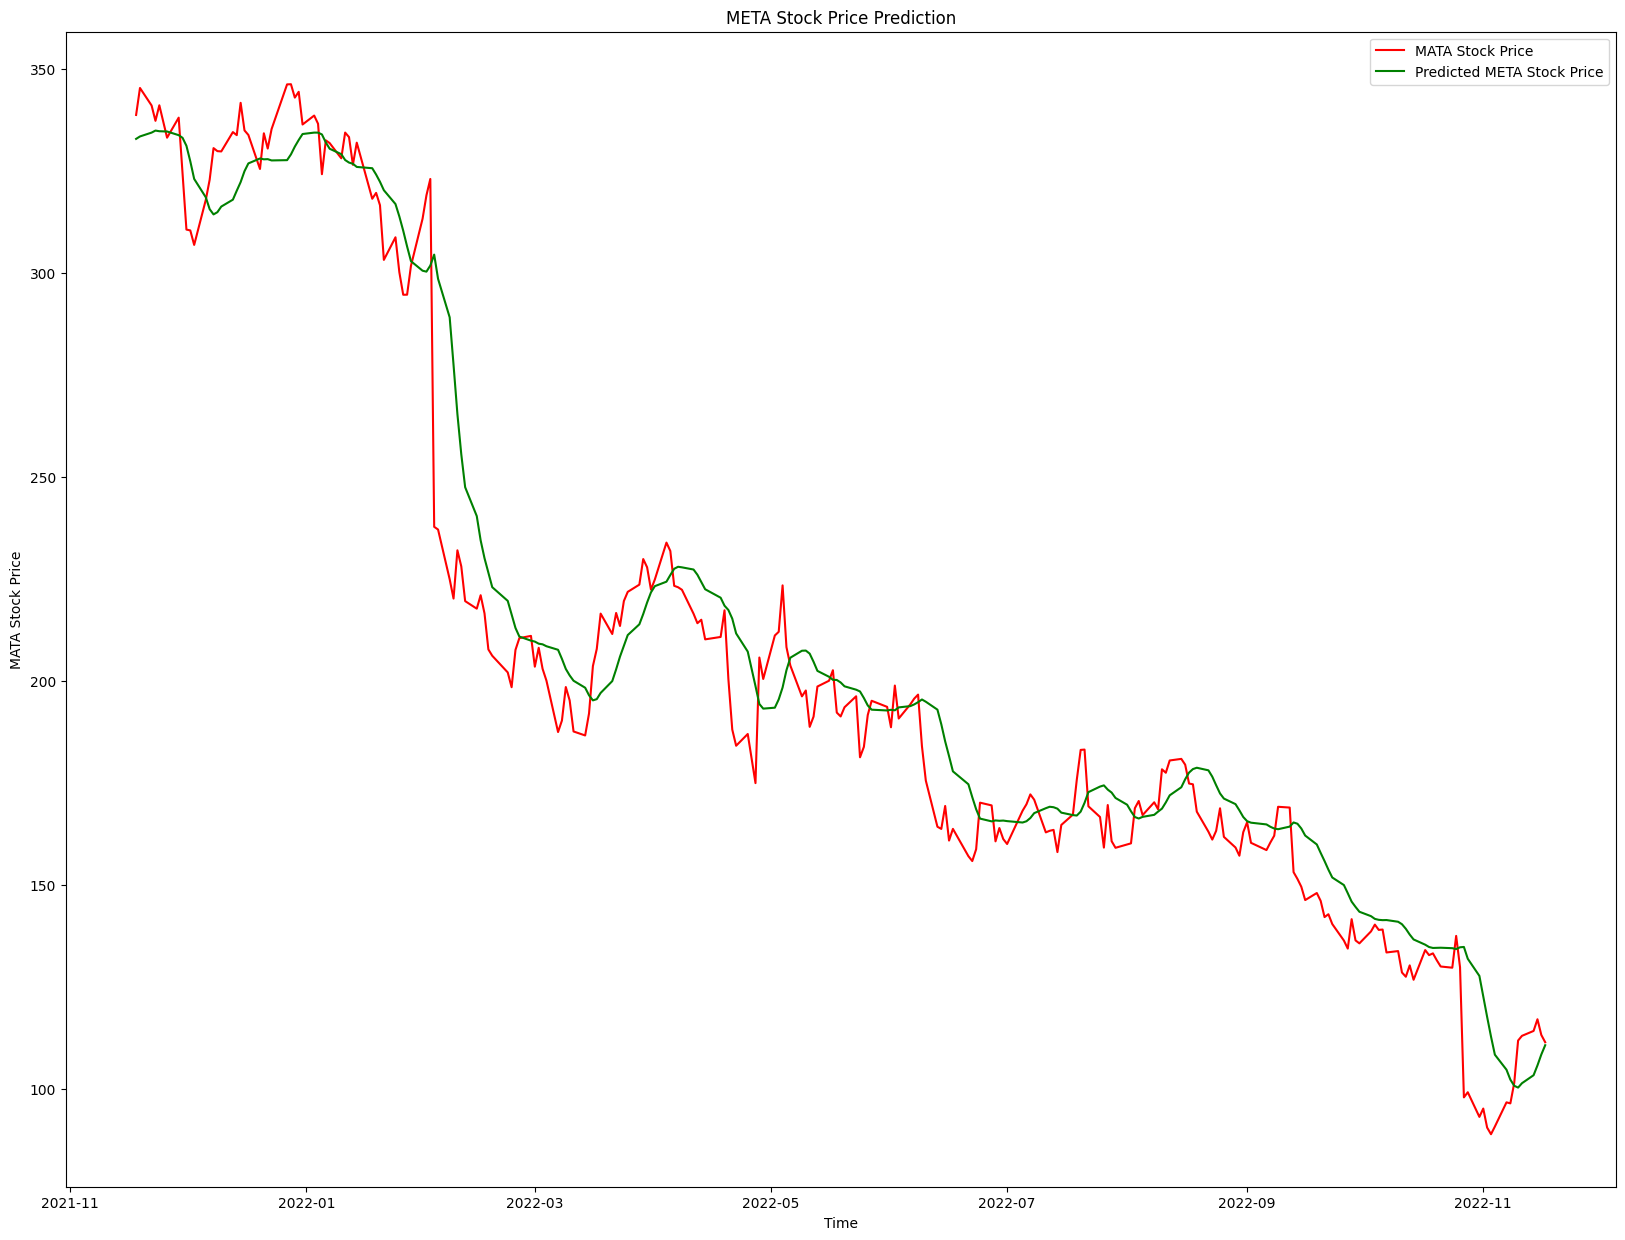

In [114]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test2=[]
for i in range(60,inputs_data2.shape[0]):
    X_test2.append(inputs_data2[i-60:i,0])
X_test2=np.array(X_test2)
X_test2=np.reshape(X_test2,(X_test2.shape[0],X_test2.shape[1],1))
predicted_closing_price2=lstm_model2.predict(X_test2)
predicted_closing_price2=scaler.inverse_transform(predicted_closing_price2)
#Save the LSTM model
lstm_model2.save("saved_model_META.h5")

#Visualize the predicted stock costs with actual stock costs
train_data2=new_dataset2[:1007]
valid_data2=new_dataset2[1007:]
valid_data2['Predictions']=predicted_closing_price2

plt.plot(valid_data2['Close'], color = 'red', label = 'MATA Stock Price')
plt.plot(valid_data2['Predictions'], color = 'green', label = 'Predicted META Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MATA Stock Price')

# displaying the title
plt.title("META Stock Price Prediction")
plt.show()

### Build and train the LSTM model for Microsoft

In [115]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data3=df3.sort_index(ascending=True,axis=0)
new_dataset3=pd.DataFrame(index=range(0,len(df3)),columns=['Date','Close'])
for i in range(0,len(data3)):
    new_dataset3["Date"][i]=data3['Date'][i]
    new_dataset3["Close"][i]=data3["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset3.index=new_dataset3.Date
new_dataset3.drop("Date",axis=1,inplace=True)
final_dataset3=new_dataset3.values

train_data3=final_dataset3[0:1007,:]
valid_data3=final_dataset3[1007:,:]

scaled_data3=scaler.fit_transform(final_dataset3)
x_train_data3,y_train_data3=[],[]
for i in range(60,len(train_data3)):
    x_train_data3.append(scaled_data3[i-60:i,0])
    y_train_data3.append(scaled_data3[i,0])

x_train_data3,y_train_data3=np.array(x_train_data3),np.array(y_train_data3)
x_train_data3=np.reshape(x_train_data3,(x_train_data3.shape[0],x_train_data3.shape[1],1))

#Build and train the LSTM model:
lstm_model3=Sequential()
lstm_model3.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data3.shape[1],1)))
lstm_model3.add(LSTM(units=50))
lstm_model3.add(Dense(1))
inputs_data3=new_dataset3[len(new_dataset3)-len(valid_data3)-60:].values
inputs_data3=inputs_data3.reshape(-1,1)
inputs_data3=scaler.transform(inputs_data3)
lstm_model3.compile(loss='mean_squared_error',optimizer='adam')
lstm_model3.fit(x_train_data3,y_train_data3,epochs=1,batch_size=1,verbose=2)

947/947 - 19s - loss: 0.0016 - 19s/epoch - 20ms/step


8/8 [==============================] - 1s 9ms/step


/var/folders/xs/h3x4fh5s5cg16zvnwkkw6l7w0000gn/T/ipykernel_1666/174300738.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data3['Predictions']=predicted_closing_price3


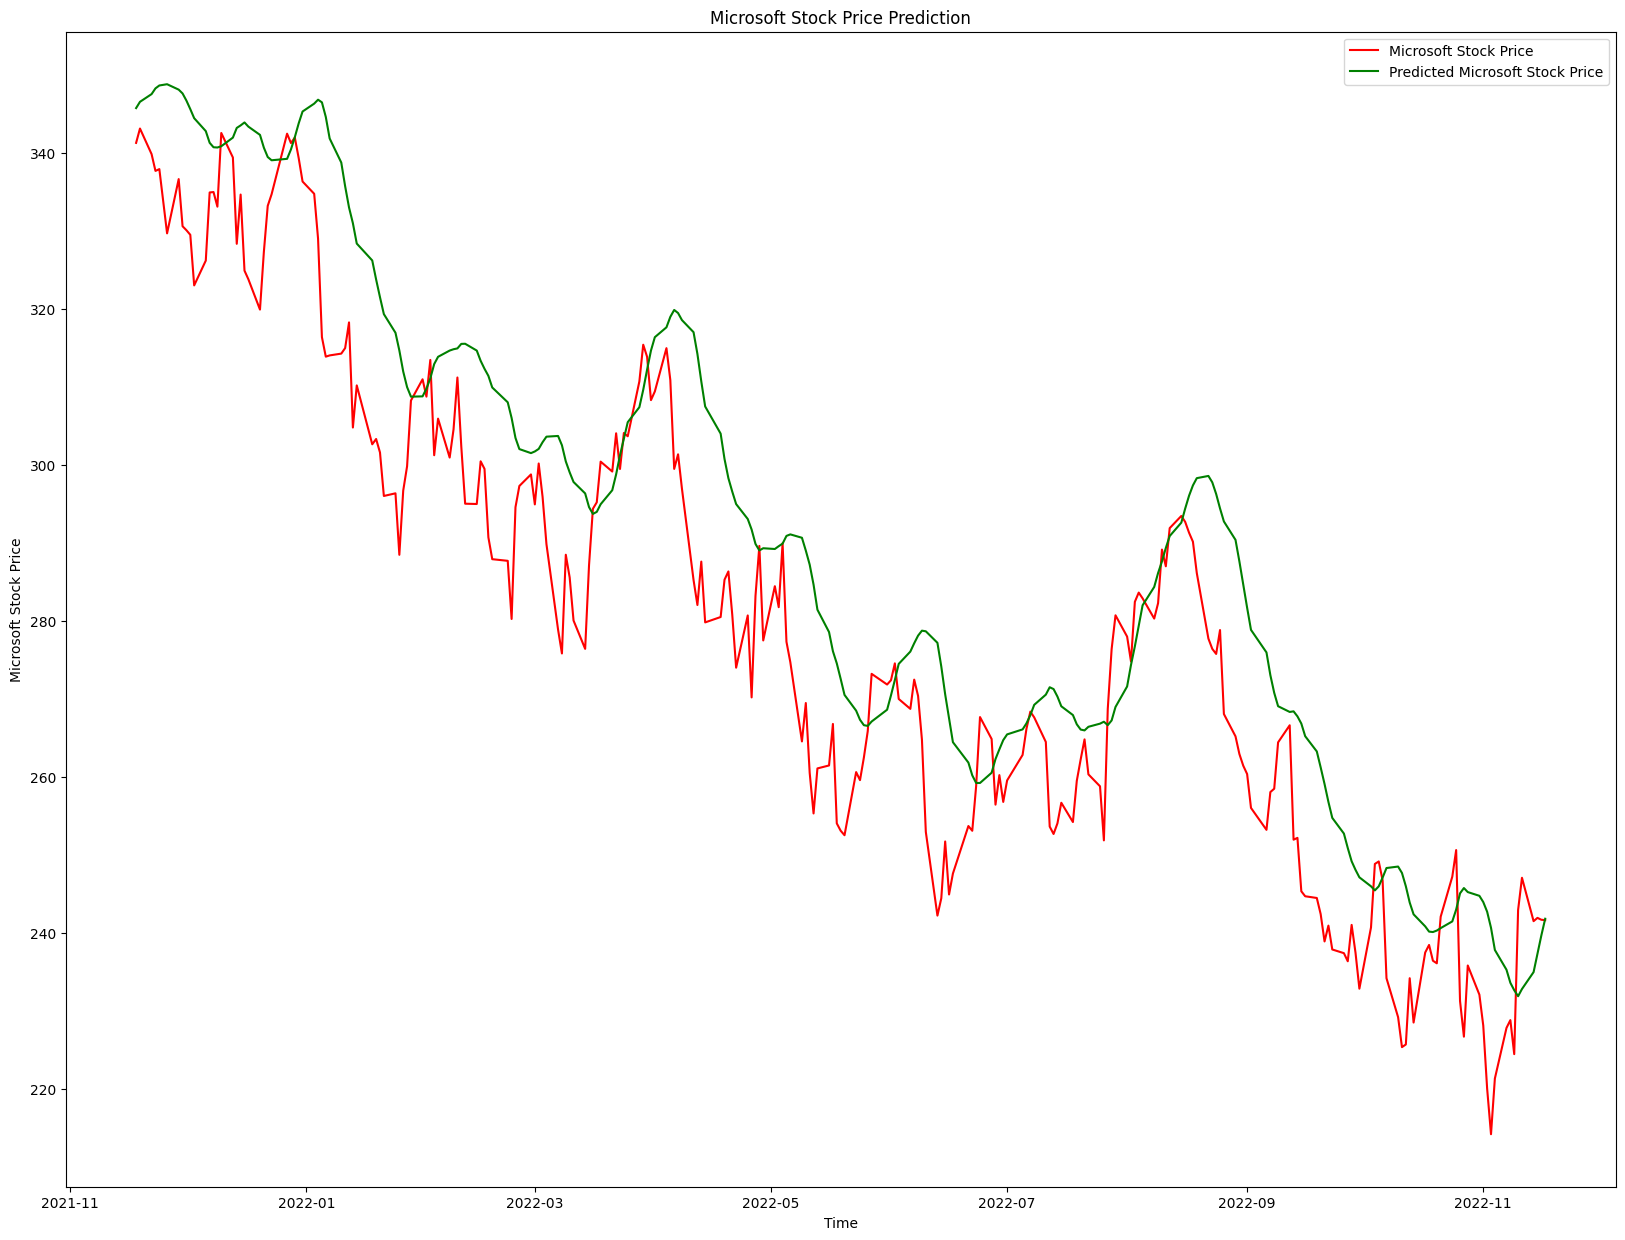

In [116]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test3=[]
for i in range(60,inputs_data3.shape[0]):
    X_test3.append(inputs_data3[i-60:i,0])
X_test3=np.array(X_test3)
X_test3=np.reshape(X_test3,(X_test3.shape[0],X_test3.shape[1],1))
predicted_closing_price3=lstm_model3.predict(X_test3)
predicted_closing_price3=scaler.inverse_transform(predicted_closing_price3)
#Save the LSTM model
lstm_model1.save("saved_model_MSFT.h5")

#Visualize the predicted stock costs with actual stock costs
train_data3=new_dataset3[:1007]
valid_data3 = new_dataset3[1007:]
valid_data3['Predictions']=predicted_closing_price3
#plt.plot(train_data1["Close"])
#plt.plot(valid_data1[['Close',"Predictions"]])
plt.plot(valid_data3['Close'], color = 'red', label = 'Microsoft Stock Price')
plt.plot(valid_data3['Predictions'], color = 'green', label = 'Predicted Microsoft Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')

# displaying the title
plt.title("Microsoft Stock Price Prediction")
plt.show()


### Build and train the LSTM model for Tesla

In [117]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data4=df4.sort_index(ascending=True,axis=0)
new_dataset4=pd.DataFrame(index=range(0,len(df4)),columns=['Date','Close'])
for i in range(0,len(data4)):
    new_dataset4["Date"][i]=data4['Date'][i]
    new_dataset4["Close"][i]=data4["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset4.index=new_dataset4.Date
new_dataset4.drop("Date",axis=1,inplace=True)
final_dataset4=new_dataset4.values

train_data4=final_dataset4[0:1007,:]
valid_data4=final_dataset4[1007:,:]

scaled_data4=scaler.fit_transform(final_dataset4)
x_train_data4,y_train_data4=[],[]
for i in range(60,len(train_data4)):
    x_train_data4.append(scaled_data4[i-60:i,0])
    y_train_data4.append(scaled_data4[i,0])

x_train_data4,y_train_data4=np.array(x_train_data4),np.array(y_train_data4)
x_train_data4=np.reshape(x_train_data4,(x_train_data4.shape[0],x_train_data4.shape[1],1))

#Build and train the LSTM model:
lstm_model4=Sequential()
lstm_model4.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data4.shape[1],1)))
lstm_model4.add(LSTM(units=50))
lstm_model4.add(Dense(1))
inputs_data4=new_dataset4[len(new_dataset4)-len(valid_data4)-60:].values
inputs_data4=inputs_data4.reshape(-1,1)
inputs_data4=scaler.transform(inputs_data4)
lstm_model4.compile(loss='mean_squared_error',optimizer='adam')
lstm_model4.fit(x_train_data4,y_train_data4,epochs=1,batch_size=1,verbose=2)

947/947 - 18s - loss: 0.0030 - 18s/epoch - 19ms/step


8/8 [==============================] - 1s 9ms/step


/var/folders/xs/h3x4fh5s5cg16zvnwkkw6l7w0000gn/T/ipykernel_1666/3397457096.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data4['Predictions']=predicted_closing_price4


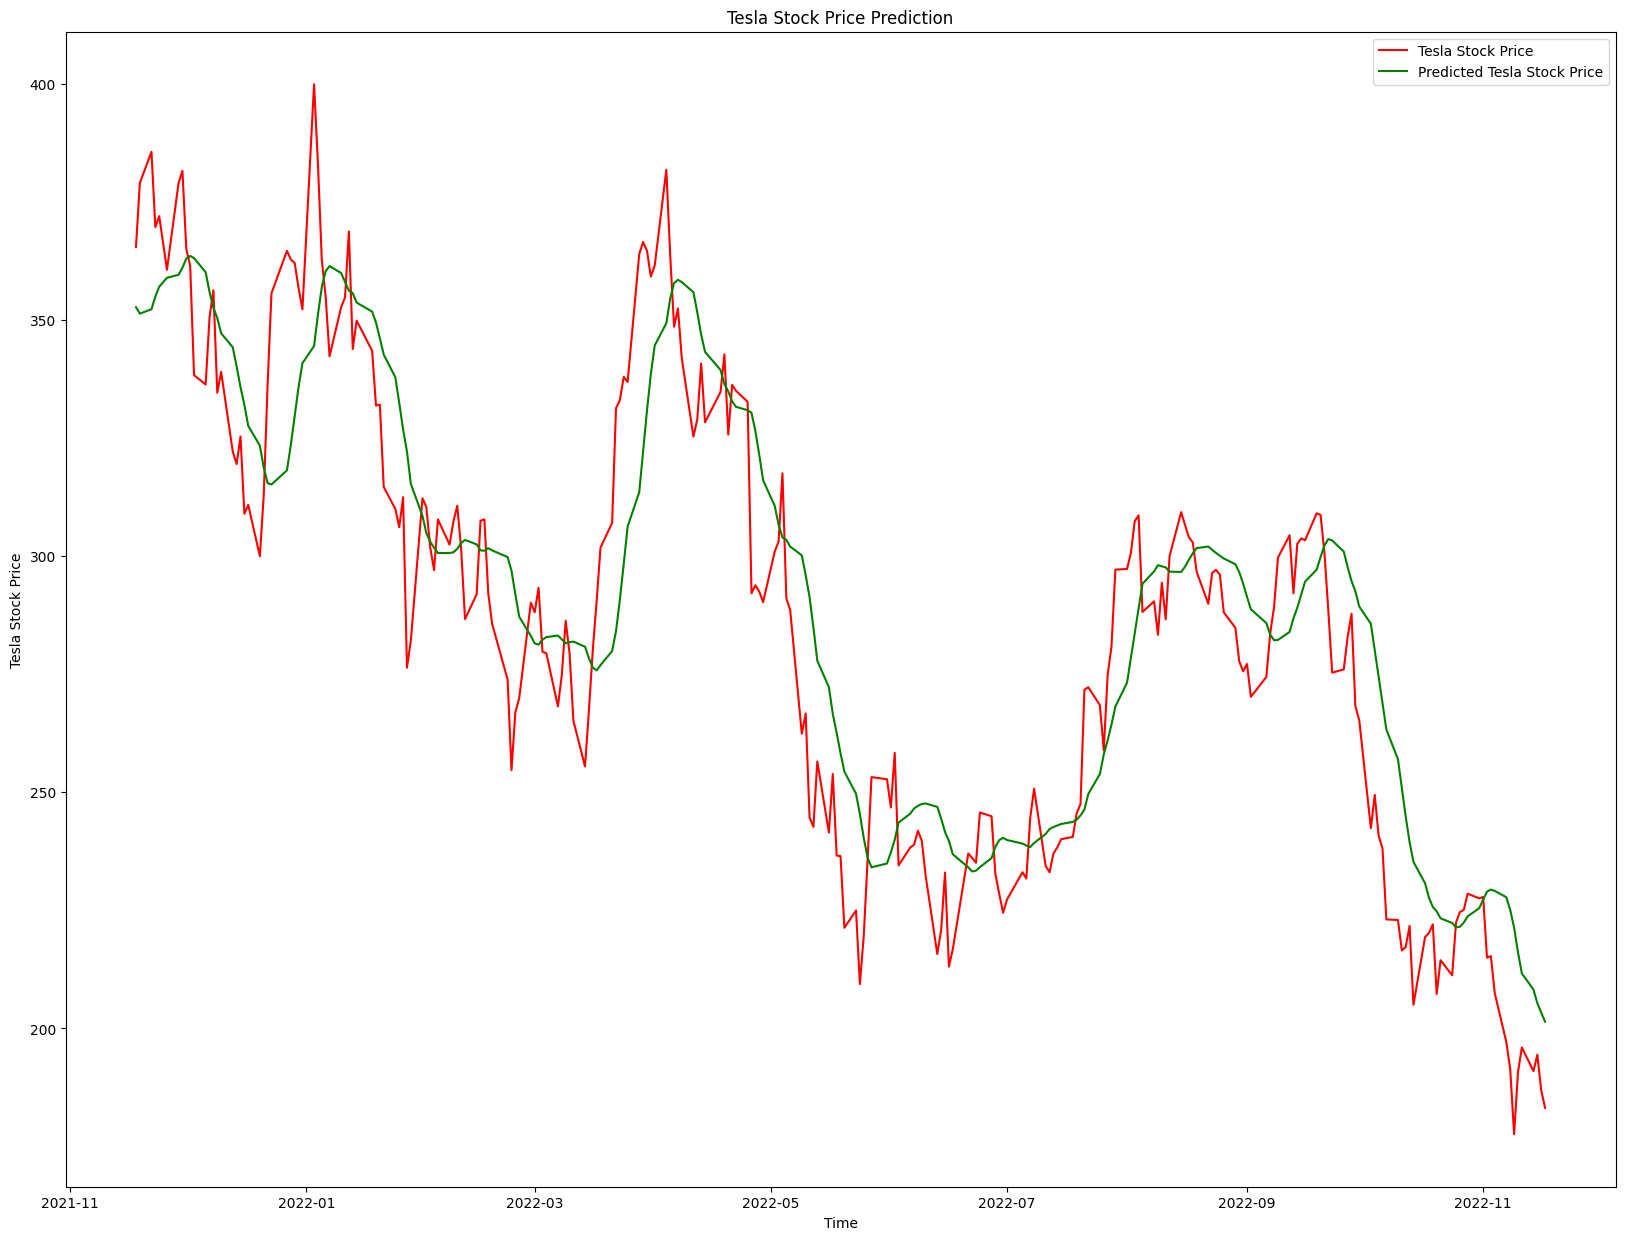

In [118]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test4=[]
for i in range(60,inputs_data4.shape[0]):
    X_test4.append(inputs_data4[i-60:i,0])
X_test4=np.array(X_test4)
X_test4=np.reshape(X_test4,(X_test4.shape[0],X_test4.shape[1],1))
predicted_closing_price4=lstm_model4.predict(X_test4)
predicted_closing_price4=scaler.inverse_transform(predicted_closing_price4)
#Save the LSTM model
lstm_model4.save("saved_model_TSLA.h5")

#Visualize the predicted stock costs with actual stock costs
train_data4=new_dataset4[:1007]
valid_data4 = new_dataset4[1007:]
valid_data4['Predictions']=predicted_closing_price4
#plt.plot(train_data1["Close"])
#plt.plot(valid_data1[['Close',"Predictions"]])
plt.plot(valid_data4['Close'], color = 'red', label = 'Tesla Stock Price')
plt.plot(valid_data4['Predictions'], color = 'green', label = 'Predicted Tesla Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')

# displaying the title
plt.title("Tesla Stock Price Prediction")
plt.show()


In [119]:
!python3 stock_app.py

2022-12-14 23:31:51.209265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 23:31:59.419539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
8/8 [==============================] - 1s 8ms/step
/Users/mollywu/PycharmProjects/CS5100-Project/stock_app.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas